In [1]:
# want to store this notebook in the notebooks folder, but want to keep non-relative imports
import os
os.chdir('..')

In [2]:
import sys
import time
import copy
import pickle
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
from torch.autograd import Variable
from itertools import repeat
import sklearn
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
from models.ml_methods import MLMethods


import models, models.graphLayer, models.models
import data, data.gene_datasets, data.graph


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#datsaet = data.gene_datasets.TCGATissue(data_dir='/data/lisa/data/genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
dataset = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [4]:
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = dataset
opt.add_self = True
opt.norm_adj = True
opt.add_connectivity = False
opt.num_layer = 1
opt.cuda = False
opt.pool_graph = "ignore"


In [5]:
# Setup the results dictionary
results_file_name = "experiments/results/fig-5/data.pkl"
try:
    results = pickle.load(open(results_file_name, "r"))
    print "Loaded Checkpointed Results"
    print ("Only " + str(dataset.df.shape[1] - len(results['df']['gene_name'].unique())) + " more genes to do...")
except Exception as e:
    results = {"df": pd.DataFrame(columns=['auc', 'gene', 'model', 'num_genes', 'seed', 'train_size'])}
    print "Created a New Results Dictionary"


Loaded Checkpointed Results
Created a New Results Dictionary


In [6]:
graph = data.graph.Graph()
path = "ae2691e4f4f068d32f83797b224eb854b27bd3ee" # Gene mania hash
#path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
graph.load_graph(path)
#graph.intersection_with(dataset)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(dataset.df.columns)), dataset.df.columns))
g = nx.relabel_nodes(g, mapping)

In [7]:
def fit_and_predict(method, X_train, X_test, y_train, y_test):
    x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()

    method.fit(X_train, y_train)
    y_hat = method.predict(x_test)[:,1].data.cpu().numpy()
    auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())

    method.best_model = None # cleanup
    return auc

def sample_neighbors(g, gene, num_neighbors, include_self=True):
    results = set([])
    if include_self:
        results = set([gene])
    all_nodes = set(g.nodes)
    first_degree = set(g.neighbors(gene))
    second_degree = set()
    for x in g.neighbors(gene):
        second_degree = second_degree.union(set(g.neighbors(x)))
    while len(results) < num_neighbors:
        if len(first_degree) - len(results) > 0:
            unique = sorted(first_degree - results)
            results.add(unique.pop())
        elif len(second_degree) - len(results) > 0:
            unique = sorted(second_degree - results)
            results.add(unique.pop())
        else:
            unique = sorted(all_nodes - results)
            results.add(unique.pop())
    return results

def record_result(results, gene, model, num_genes, train_size, seed, auc, results_file_name):
    experiment = {
        "gene": gene,
        "model": model,
        "num_genes": num_genes,
        "seed": seed,
        "train_size": train_size,
        "auc": auc
    }

    results["df"] = results["df"].append(experiment, ignore_index=True)
    results_dir = "/".join(results_file_name.split('/')[0:-1])

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    pickle.dump(results, open(results_file_name, "wb"))

def record_failure(results, gene, model, num_genes, train_size, trials, results_file_name):
    for temp_seed in range(trials):
        record_result(results, gene, model, num_genes, train_size, temp_seed, "N/A", results_file_name)
        record_result(results, gene, model, num_genes, train_size, temp_seed, "N/A", results_file_name)

        
def check_if_done(df, gene, model, num_genes, train_size, seed):
    already_done = results["df"][(results["df"].gene == gene) &
                                 (results["df"].model == model) &
                                 (results["df"].num_genes == num_genes) &
                                 (results["df"].seed == seed) &
                                 (results["df"].train_size == train_size)].shape[0] > 0
    return already_done



In [8]:
m = [
    {'key': 'CGN_lay3_chan64_emb32_dropout', 'method': MLMethods(model_name="CGN", cuda=opt.cuda, num_layer=3, num_channel=64, add_emb=32 )},
    {'key': 'MLP_lay2_chan512_dropout', 'method': MLMethods(model_name="MLP", cuda=opt.cuda, dropout=True, num_layer=2, num_channel=512)},
    {'key': 'MLP_lay2_chan512', 'method': MLMethods(model_name="MLP", cuda=opt.cuda, dropout=False, num_layer=2, num_channel=512)},
    {'key': 'SLR_lambda1_l11', 'method': MLMethods(model_name="SLR", cuda=opt.cuda)},
    {'key': 'CGN_lay20_chan32_emb32_dropout_pool', 'method': MLMethods(model_name="CGN", cuda=opt.cuda, num_layer=4, num_channel=32, add_emb=32, prepool_extralayers=5)}  
]

In [9]:
search_num_genes=[50, 100, 200, 300, 500, 1000, 2000, 4000, 8000, 16000]
test_size=1000
search_train_size=[50]
trials=5
genes = ["CEBPD", "IL5", "PABPC3", "PSMB10", "RPL13", "RPL4", "RPL5", "RPS10", "RPS3", "S100A8", "S100A9", "TOP1", "C15orf40", "RNF138", "DLGAP2", "EVI2B", "ZFP82", "MYBL2", "PSMB1", "CISD1", "HLA-B", "SAA2", "IFIT1", "RPS3A", "TP53", "TNF", "EGFR"]

In [ ]:
# def method_comparison(results, dataset, models, gene, search_num_genes, trials, search_train_size, test_size):
dataset.df = dataset.df - dataset.df.mean()
dataset.data = dataset.df.as_matrix()
for gene in genes:
    mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > mean else 0 for x in dataset.df[gene]]

    for train_size in search_train_size:
        for num_genes in search_num_genes:

            num_genes = np.min([num_genes, dataset.df.shape[1]])
            neighbors = sample_neighbors(g, gene, num_genes, include_self=True)
            neighborhood = np.asarray(nx.to_numpy_matrix(g.subgraph(neighbors)))
            
            for model in m:
                for seed in range(trials):

                    already_done = check_if_done(results["df"], gene, model['key'], num_genes, train_size, seed)
                    if already_done:
                        print "already done:", model['key'], "num_genes", num_genes, "train_size", train_size, "seed", seed
                        continue

                    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size*2, test_size=test_size, random_state=seed)

                    X_train = X_train[list(neighbors)].copy()
                    X_train[gene] = 1
                    X_test = X_test[list(neighbors)].copy()
                    X_test[gene] = 1

                    if len(set(y_train)) <= 1 or len(set(y_test)) <= 1 or type(neighborhood) != np.ndarray:
                        record_failure(results, gene, model['key'], num_genes, trials, train_size, results_file_name)
                        continue
                    print "doing:", model['key'], "num_genes", num_genes, "train_size", train_size, "seed", seed

                    model['method'].fit(X_train, y_train, adj=neighborhood)
                    x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
                    y_hat = model['method'].predict(x_test)[:,1].data.cpu().numpy()
                    auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
                    model['method'].best_model = None
                    
                    record_result(results, gene, model['key'], num_genes, train_size, seed, auc, results_file_name)

already done: CGN_lay3_chan64_emb32_dropout num_genes 50 train_size 50 seed 0
already done: CGN_lay3_chan64_emb32_dropout num_genes 50 train_size 50 seed 1
already done: CGN_lay3_chan64_emb32_dropout num_genes 50 train_size 50 seed 2
already done: CGN_lay3_chan64_emb32_dropout num_genes 50 train_size 50 seed 3
already done: CGN_lay3_chan64_emb32_dropout num_genes 50 train_size 50 seed 4
already done: MLP_lay2_chan512_dropout num_genes 50 train_size 50 seed 0
already done: MLP_lay2_chan512_dropout num_genes 50 train_size 50 seed 1
already done: MLP_lay2_chan512_dropout num_genes 50 train_size 50 seed 2
already done: MLP_lay2_chan512_dropout num_genes 50 train_size 50 seed 3
already done: MLP_lay2_chan512_dropout num_genes 50 train_size 50 seed 4
already done: MLP_lay2_chan512 num_genes 50 train_size 50 seed 0
already done: MLP_lay2_chan512 num_genes 50 train_size 50 seed 1
already done: MLP_lay2_chan512 num_genes 50 train_size 50 seed 2
already done: MLP_lay2_chan512 num_genes 50 train_

doing: CGN_lay3_chan64_emb32_dropout num_genes 1000 train_size 50 seed 0
doing: CGN_lay3_chan64_emb32_dropout num_genes 1000 train_size 50 seed 1


34


IOError: [Errno 2] No such file or directory: 'figs/sgi-CEBPD-train50.png'

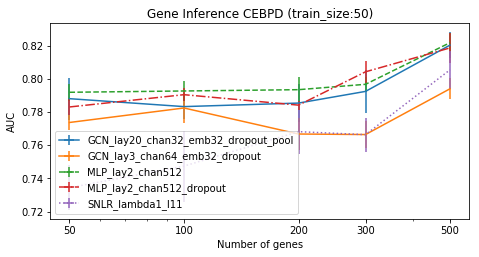

In [19]:

for gene in genes:

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (7.5, 3.6)
    plot_train_size = 50

    subset = results["df"][(results["df"].train_size==plot_train_size) & 
                      (results["df"].gene==plot_gene) & 
                      (results["df"].num_genes!=400) &      
                      (results["df"].num_genes> 0)]


    q = subset.groupby(['model','num_genes'])['auc']

    #['CGN_2_layer_512_channel_emb_512_dropout', "MLP_2_chan512", "SLR2=lambda10-l1-1"]:
    #for model in ['CGN_2_layer_512_channel_emb_512_dropout', "MLP_2_chan512", "SLR2=lambda10-l1-1"]:

    todo = list(subset["model"].unique())
    linestyles = ['-', '-', '--', '-.', ':']
    for ls, model in enumerate(sorted(todo)):
        index = list(q.mean()[model].index)
        mean = q.mean()[model]
        stderr = q.std()[model]/np.sqrt(q.count()[model])
        displayname = model.replace("CGN","GCN")
        displayname = displayname.replace("SLR", "SNLR")
        plt.errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, ls=linestyles[ls])

    plt.title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
    plt.ylabel("AUC")
    plt.xlabel("Number of genes")
    plt.xscale("log")
    plt.xticks(sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter()
    plt.gca().xaxis.set_major_formatter(formatter)
    #plt.xlim(40,4500)

    plt.legend();
    fd = len(list(g.neighbors(plot_gene)))
    print fd
    if fd > 50:
        plt.axvline(fd, ymin=0.4, ymax=1.0, c="black")
        c = plt.ylim()
        plt.text(fd*1.05,c[1]-((c[1]-c[0])*0.2),'First Degree',rotation=90)



    # plt.savefig("figs/sgi-" + plot_gene + "-" + "train" + str(plot_train_size) + ".png", bbox_inches='tight')
    plt.show()